In [90]:
import pandas as pd
import seaborn as sns
import sys
import shap
import uuid
sys.path.append('/Users/alexander_wong/Documents/playlist-success/')
from datetime import datetime

from src.constants import *
from pycaret.classification import *
from src.data_transformations import create_features, classify_success

pd.options.display.max_columns = 200
sns.set_style('darkgrid')

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = pd.read_parquet("../data/streamlit_data.parquet")

In [84]:
sorted(data["genre_1"].unique())

['-',
 'Alternative',
 'Blues',
 "Children's",
 'Classical',
 'Country & Folk',
 'Dance & House',
 'Easy Listening',
 'Electronica',
 'Holiday',
 'Indie Rock',
 'Jazz',
 'Latin',
 'Metal',
 'New Age',
 'Other',
 'Pop',
 'Punk',
 'R&B',
 'Rap',
 'Reggae',
 'Religious',
 'Rock',
 'Soundtrack',
 'Spoken & Audio',
 'Traditional']

In [85]:
labelled_frame = classify_success(data, users_threshold=10, success_threshold=0.75)

INFO:root:# of playlists: 68352
INFO:root:# of playlists above the users_threshold: 61217
INFO:root:% of playlists removed: 7135
INFO:root:% of playlists remaining: 89.6


In [89]:
labelled_frame.groupby("genre_1")[["streaming_ratio_users"]].quantile(0.75).reset_index().sort_values(by='streaming_ratio_users', ascending=False)

,genre_1,streaming_ratio_users
14,New Age,12.073718
7,Easy Listening,11.769231
21,Religious,11.120942
11,Jazz,9.337302
10,Indie Rock,8.888889
12,Latin,8.815657
24,Spoken & Audio,8.762133
4,Classical,8.660714
3,Children's,8.538462
5,Country & Folk,8.462008


In [77]:
def create_holdout(frame, holdout_fraction):
    target_frame = frame[
                ["success_streaming_ratio_users", "playlist_uri"]
                + MODEL_NUMERICAL_FEATURES
                + MODEL_CATEGORICAL_FEATURES
            ]

    success_frame = target_frame.loc[
            lambda f: f["success_streaming_ratio_users"] == 1
        ]
    non_success_frame = target_frame.loc[
            lambda f: f["success_streaming_ratio_users"] == 0
        ]
    
    holdout_size = int(holdout_fraction * len(success_frame))

    holdout_frame_success = success_frame.sample(
        n=holdout_size, replace=False, random_state=69
    )
    holdout_frame_non_success = non_success_frame.sample(
        n=holdout_size, replace=False, random_state=69
    )

    train_frame_success = success_frame.loc[
        lambda f: ~f["playlist_uri"].isin(holdout_frame_success["playlist_uri"])
    ]
    train_frame_non_success = non_success_frame.loc[
        lambda f: ~f["playlist_uri"].isin(holdout_frame_non_success["playlist_uri"])
    ]

    holdout_frame = pd.concat(
        [holdout_frame_success, holdout_frame_non_success]
    ).reset_index(drop=True)
    
    train_frame = pd.concat(
        [train_frame_success, train_frame_non_success]
    ).reset_index(drop=True)
    return train_frame, holdout_frame

In [6]:
train_frame, holdout_frame = create_holdout(labelled_frame, holdout_fraction=0.10)

In [81]:
timestamp = str(datetime.now()).split(".")[0].replace(" ","")
experiment_name = f"AW_spotify_demo_{timestamp}"

In [82]:
experiment_name

'AW_spotify_demo_2021-04-1302:05:36'

In [10]:
experiment = setup(
    data = train_frame,
    numeric_features = MODEL_NUMERICAL_FEATURES,
    categorical_features = MODEL_CATEGORICAL_FEATURES,
    target = "success_streaming_ratio_users", 
    ignore_features=["playlist_uri"],
    test_data = holdout_frame,
    session_id=123,
    ignore_low_variance = True,
    remove_outliers = True,
    fix_imbalance = True,
    remove_multicollinearity = True,
    log_experiment = True,
    log_data = True,
    fold = 2, 
    n_jobs = -1,
    combine_rare_levels=True,
    experiment_name = experiment_name)

,Description,Value
0,session_id,123
1,Target,success_streaming_ratio_users
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(58155, 54)"
5,Missing Values,True
6,Numeric Features,46
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:Logging experiment in MLFlow
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['genre_1',
                                                            'genre_2',
                                                            'genre_3', 'mood_1',
                                                            'mood_2',
                                                            'mood_3'],
                                      display_types=True,
                                      features_todrop=['playlist_uri'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['n_tracks',
                                                          'n_artists',
                  

In [11]:
models = compare_models(n_select=20, round=3, cross_validation=False, include=["et", "rf", "lightgbm", "dt", "xgboost"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.575,0.728,0.208,0.781,0.328,0.150,0.220,16.340
lightgbm,Light Gradient Boosting Machine,0.567,0.733,0.171,0.824,0.283,0.135,0.220,2.720
rf,Random Forest Classifier,0.560,0.725,0.156,0.812,0.261,0.120,0.203,8.410
et,Extra Trees Classifier,0.556,0.701,0.154,0.787,0.258,0.112,0.189,10.150
dt,Decision Tree Classifier,0.549,0.549,0.366,0.577,0.448,0.098,0.105,7.050


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 2
INFO:logs:[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
     

In [16]:
exp = pull()

In [17]:
exp

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.575,0.728,0.208,0.781,0.328,0.150,0.220,16.34
lightgbm,Light Gradient Boosting Machine,0.567,0.733,0.171,0.824,0.283,0.135,0.220,2.72
rf,Random Forest Classifier,0.560,0.725,0.156,0.812,0.261,0.120,0.203,8.41
et,Extra Trees Classifier,0.556,0.701,0.154,0.787,0.258,0.112,0.189,10.15
dt,Decision Tree Classifier,0.549,0.549,0.366,0.577,0.448,0.098,0.105,7.05


In [18]:
dict_models = {}
for i, model in enumerate(exp.index):
    dict_models[model] = i 
    
display(dict_models)

{'xgboost': 0, 'lightgbm': 1, 'rf': 2, 'et': 3, 'dt': 4}

In [19]:
selected_model = models[dict_models["xgboost"]]
display(selected_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)

In [21]:
tuned_model = tune_model(selected_model, round= 3, n_iter=5, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.609,0.683,0.691,0.336,0.452,0.201,0.233
1,0.609,0.684,0.681,0.334,0.448,0.196,0.226
Mean,0.609,0.684,0.686,0.335,0.450,0.199,0.230
SD,0.000,0.001,0.005,0.001,0.002,0.003,0.003


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)
INFO:logs:tune_model() succesfully completed......................................


In [22]:
predict_model(tuned_model)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0), probability_threshold=None, encoded_labels=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5748,0.7276,0.2077,0.7813,0.3282,0.1496,0.2203


,n_tracks,n_albums,tracks_per_album,artists_per_album,title_length,acousticness_percentile_25p0,danceability_percentile_25p0,duration_percentile_25p0,instrumentalness_percentile_25p0,liveness_percentile_25p0,...,mood_3_Somber,mood_3_Sophisticated,mood_3_Tender,mood_3_Upbeat,mood_3_Urgent,mood_3_Yearning,mood_3_others_infrequent,success_streaming_ratio_users,Label,Score
0,42.0,40.0,1.050000,0.900000,1.0,0.009580,0.55600,210960.00,0.000000,0.095300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.8641
1,151.0,110.0,1.372727,0.927273,2.0,0.412000,0.64450,153120.00,0.000000,0.083150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.5299
2,72.0,71.0,1.014084,0.985915,2.0,0.448500,0.49100,192040.00,0.000000,0.099950,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.6984
3,100.0,1.0,100.000000,74.000000,6.0,0.000225,0.44750,219939.75,0.002498,0.093000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9336
4,205.0,143.0,1.433566,0.727273,2.0,0.008450,0.50800,214053.00,0.000006,0.088100,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0.6598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3057,196.0,10.0,19.600000,2.900000,3.0,0.146500,0.40700,207526.75,0.000010,0.093775,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.7544
3058,6.0,5.0,1.200000,1.000000,1.0,0.711000,0.17500,219747.00,0.768000,0.095900,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.8470
3059,13.0,1.0,13.000000,2.000000,4.0,0.882000,0.12800,110867.00,0.911000,0.095500,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.9482
3060,62.0,37.0,1.675676,1.297297,2.0,0.064850,0.53450,212485.75,0.000000,0.100550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8168


In [ ]:
##### CHECKPOINT  #####
# selected_model = create_model('xgboost')

In [ ]:
# There's actually a way of retrieving it after setup @sparvaneh . The setup documentation is this: "This function returns various outputs that are stored in variables as tuples. They are used by other functions in pycaret.". However, after analyzing the source code I found out that the function returns a tuple with this content:
# X
# y
# X_train
# X_test
# y_train
# y_test
# seed
# prep_pipe
# experiment__
# So if you have a variable with the content return by the setup function you can retrieve the train/test data back by accessing its corresponding tuple index. For example my_setup = setup(...) then X_test_data = my_setup[3].

In [18]:
experiment[6]

{'lr': <pycaret.containers.models.classification.LogisticRegressionClassifierContainer at 0x7fd5099160d0>,
 'knn': <pycaret.containers.models.classification.KNeighborsClassifierContainer at 0x7fd509916130>,
 'nb': <pycaret.containers.models.classification.GaussianNBClassifierContainer at 0x7fd5099161c0>,
 'dt': <pycaret.containers.models.classification.DecisionTreeClassifierContainer at 0x7fd509916460>,
 'svm': <pycaret.containers.models.classification.SGDClassifierContainer at 0x7fd509916490>,
 'rbfsvm': <pycaret.containers.models.classification.SVCClassifierContainer at 0x7fd509916a00>,
 'gpc': <pycaret.containers.models.classification.GaussianProcessClassifierContainer at 0x7fd509916af0>,
 'mlp': <pycaret.containers.models.classification.MLPClassifierContainer at 0x7fd509916bb0>,
 'ridge': <pycaret.containers.models.classification.RidgeClassifierContainer at 0x7fd509916e50>,
 'rf': <pycaret.containers.models.classification.RandomForestClassifierContainer at 0x7fd509913ca0>,
 'qda': 

In [28]:
experiment[10].shape

(55247,)

In [30]:
experiment[11].shape

(55247, 173)

In [32]:
experiment

({'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 -1,
 [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                i

In [49]:
# X_train = experiment[1][1][1]
# y_train = experiment[1][2][1]

X_train = get_config(variable="X_train")
y_train = get_config(variable="y_train")

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_train)
INFO:logs:Global variable: X_train returned as        n_tracks  n_albums  tracks_per_album  artists_per_album  title_length  \
0         144.0     114.0          1.263158           0.798246           2.0   
1         210.0     122.0          1.721311           0.778689           3.0   
2          57.0      53.0          1.075472           0.886792           2.0   
4         147.0      13.0         11.307693           0.153846           3.0   
5         221.0     172.0          1.284884           1.034884           2.0   
...         ...       ...               ...                ...           ...   
58150     361.0     180.0          2.005556           1.422222           1.0   
58151      24.0       1.0         24.000000           8.000000           2.0   
58152      59.0       1.0         59.000000           1.000000           2.0   
58153      16.0       1.0         16.000000          11.000000           6.0  

In [52]:
y_train

0        1
1        1
2        1
4        1
5        1
        ..
58150    0
58151    0
58152    0
58153    0
58154    0
Name: success_streaming_ratio_users, Length: 55247, dtype: int64

In [50]:
explainer = shap.TreeExplainer(tuned_model)

In [53]:
shap_values = explainer.shap_values(X_train.to_numpy(), y_train)

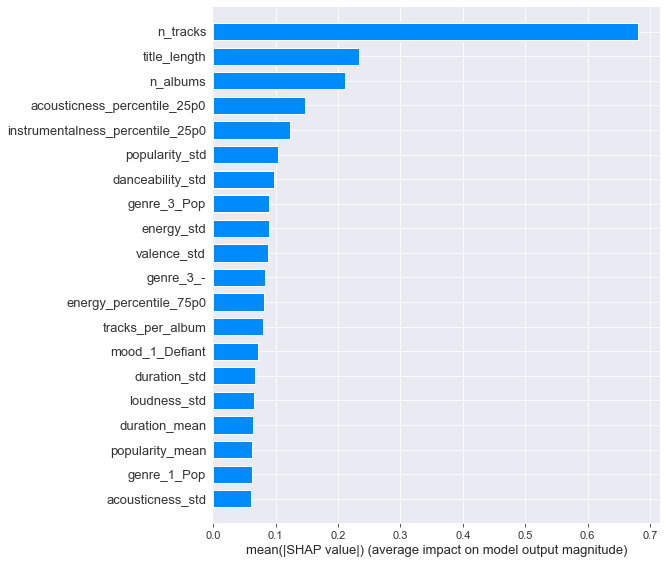

In [54]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

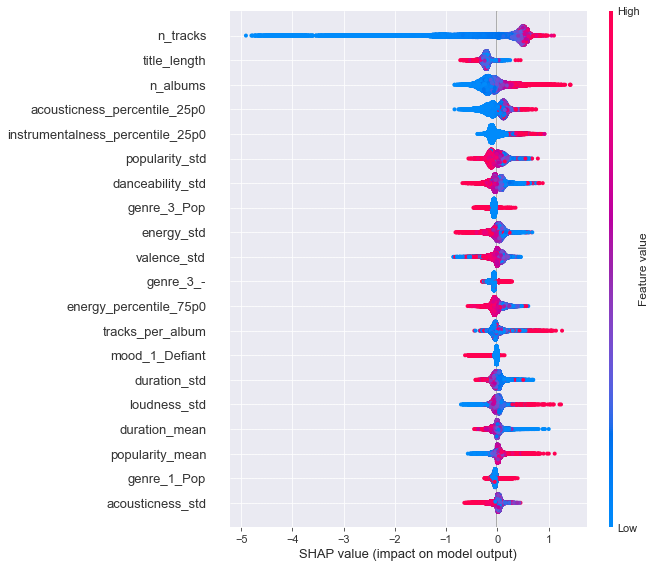

In [55]:
shap.summary_plot(shap_values, X_train, show=True)

In [62]:
view = pd.merge(y_train, X_train, left_index=True, right_index=True)

In [63]:
view

,success_streaming_ratio_users,n_tracks,n_albums,tracks_per_album,artists_per_album,title_length,acousticness_percentile_25p0,danceability_percentile_25p0,duration_percentile_25p0,instrumentalness_percentile_25p0,...,mood_3_Rowdy,mood_3_Sensual,mood_3_Sentimental,mood_3_Somber,mood_3_Sophisticated,mood_3_Tender,mood_3_Upbeat,mood_3_Urgent,mood_3_Yearning,mood_3_others_infrequent
0,1,144.0,114.0,1.263158,0.798246,2.0,0.03250,0.47875,192187.00,0.000003,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,210.0,122.0,1.721311,0.778689,3.0,0.00216,0.42400,209973.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,57.0,53.0,1.075472,0.886792,2.0,0.03110,0.53575,214063.25,0.000123,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,147.0,13.0,11.307693,0.153846,3.0,0.01865,0.46950,193113.50,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,1,221.0,172.0,1.284884,1.034884,2.0,0.03150,0.62100,172756.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58150,0,361.0,180.0,2.005556,1.422222,1.0,0.01080,0.57000,201653.50,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58151,0,24.0,1.0,24.000000,8.000000,2.0,0.65250,0.45450,99107.00,0.175950,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58152,0,59.0,1.0,59.000000,1.000000,2.0,0.23350,0.47200,227107.00,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
58153,0,16.0,1.0,16.000000,11.000000,6.0,0.16525,0.37675,161748.50,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
from src.model import PlaylistSuccessPredictor, ShapObject
row=4

shap_object = ShapObject(base_values=explainer.expected_value,
                                 values=explainer.shap_values(X_train)[row, :],
                                 feature_names=X_train.columns,
                                 data=X_train.iloc[row, :])

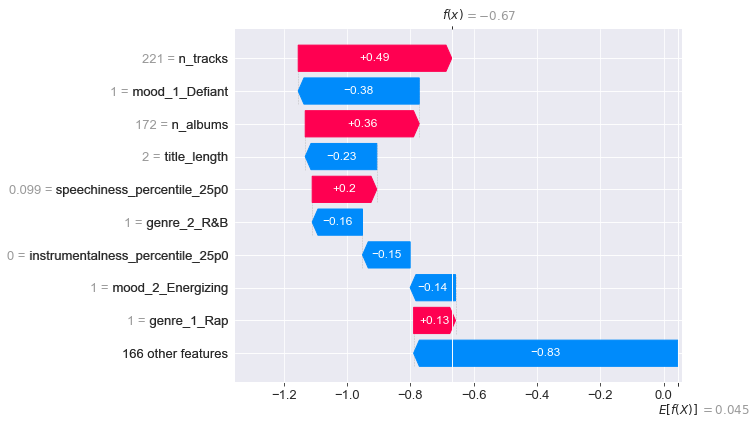

In [65]:
shap.waterfall_plot(shap_object)

In [66]:
features = list(pd.DataFrame({"featres": shap_object.feature_names, "shap_values": shap_object.values}).sort_values(by='shap_values', ascending=False)["featres"][:20])

In [67]:
features

['n_tracks',
 'n_albums',
 'speechiness_percentile_25p0',
 'genre_1_Rap',
 'liveness_std',
 'duration_mean',
 'energy_percentile_75p0',
 'genre_1_Country & Folk',
 'liveness_percentile_25p0',
 'valence_percentile_25p0',
 'instrumentalness_std',
 'acousticness_percentile_75p0',
 'genre_1_Latin',
 'instrumentalness_mean',
 'mood_1_Energizing',
 'valence_std',
 'loudness_percentile_25p0',
 'danceability_percentile_25p0',
 'mood_1_Lively',
 'popularity_mean']

In [68]:
feature = features[0]

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0), use_train_data=False, feature=title_length, kwargs={'interaction_index': 'n_tracks'}, observation=None, plot=correlation, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: correlation
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values
INFO:logs:mo

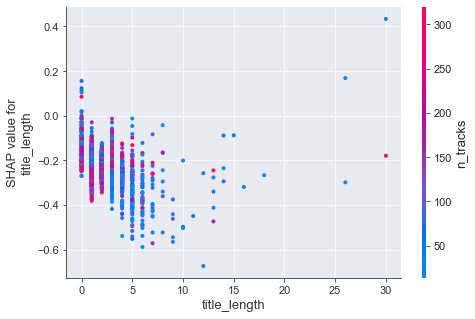

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [71]:
interpret_model(selected_model, plot='correlation', feature="title_length", interaction_index="n_tracks")

In [ ]:
interpret_model(selected_model, plot='reason', observation=2)

In [57]:
interpret_model(selected_model, plot='reason', observation=2)

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0), use_train_data=False, feature=None, kwargs={}, observation=2, plot=reason, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: reason
INFO:logs:model type detected: type 2
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [10]:
# CHECKPOINT 
# selected_model = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6452,0.0000,0.6394,0.3558,0.4572,0.2243,0.2456
1,0.6513,0.0000,0.6337,0.3601,0.4592,0.2297,0.2497
Mean,0.6483,0.0000,0.6366,0.3579,0.4582,0.2270,0.2476
SD,0.0030,0.0000,0.0029,0.0021,0.0010,0.0027,0.0020


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=123, solver='auto',
                tol=0.001)
INFO:logs:create_model() succesfully completed......................................


In [13]:
calibrated_model = calibrate_model(selected_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6468,0.6955,0.6354,0.3565,0.4567,0.2246,0.2452
1,0.6525,0.6966,0.6286,0.3603,0.4581,0.2291,0.2483
Mean,0.6496,0.6960,0.6320,0.3584,0.4574,0.2268,0.2468
SD,0.0028,0.0006,0.0034,0.0019,0.0007,0.0022,0.0015


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 4
INFO:logs:CalibratedClassifierCV(base_estimator=RidgeClassifier(alpha=1.0,
                                                      class_weight=None,
                                                      copy_X=True,
                                                      fit_intercept=True,
                                                      max_iter=None,
                                                      normalize=False,
                                                      random_state=123,
                                                      solver='auto',
                                                      tol=0.001),
                       cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
                       method='sigmoid')
INFO:logs:calibrate_model() succesfully completed......................................


In [ ]:
plot: str, default = ‘summary’
Type of plot. Available options are: ‘summary’, ‘correlation’, and ‘reason’.

In [14]:
#     * 'auc' - Area Under the Curve
#     * 'threshold' - Discrimination Threshold
#     * 'pr' - Precision Recall Curve
#     * 'confusion_matrix' - Confusion Matrix
#     * 'error' - Class Prediction Error
#     * 'class_report' - Classification Report
#     * 'boundary' - Decision Boundary
#     * 'rfe' - Recursive Feature Selection
#     * 'learning' - Learning Curve
#     * 'manifold' - Manifold Learning
#     * 'calibration' - Calibration Curve
#     * 'vc' - Validation Curve
#     * 'dimension' - Dimension Learning
#     * 'feature' - Feature Importance
#     * 'feature_all' - Feature Importance (All)
#     * 'parameter' - Model Hyperparameter
#     * 'lift' - Lift Curve
#     * 'gain' - Gain Chart
#     * 'tree' - Decision Tree

plot_model(calibrated_model, plot = 'feature')

INFO:logs:Initializing plot_model()
INFO:logs:plot_model(plot=feature, fold=None, use_train_data=False, verbose=True, is_in_evaluate=False, display=None, display_format=None, estimator=CalibratedClassifierCV(base_estimator=RidgeClassifier(alpha=1.0,
                                                      class_weight=None,
                                                      copy_X=True,
                                                      fit_intercept=True,
                                                      max_iter=None,
                                                      normalize=False,
                                                      random_state=123,
                                                      solver='auto',
                                                      tol=0.001),
                       cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
                       method='sigmoid'), feature_name=None, fit_kwargs=None, groups=None, label=Fal

TypeError: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

In [27]:
interpret_model(calibrated_model)

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=CalibratedClassifierCV(base_estimator=RidgeClassifier(alpha=1.0,
                                                      class_weight=None,
                                                      copy_X=True,
                                                      fit_intercept=True,
                                                      max_iter=None,
                                                      normalize=False,
                                                      random_state=123,
                                                      solver='auto',
                                                      tol=0.001),
                       cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
                       method='sigmoid'), use_train_data=False, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions


TypeError: This function only supports tree based models for binary classification: et, rf, lightgbm, dt, xgboost.

In [20]:
calibrated_model

CalibratedClassifierCV(base_estimator=RidgeClassifier(alpha=1.0,
                                                      class_weight=None,
                                                      copy_X=True,
                                                      fit_intercept=True,
                                                      max_iter=None,
                                                      normalize=False,
                                                      random_state=123,
                                                      solver='auto',
                                                      tol=0.001),
                       cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
                       method='sigmoid')

In [21]:
selected_model

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=123, solver='auto',
                tol=0.001)

In [ ]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)

In [ ]:
evaluate_model(tuned_catboost)

In [16]:
compare_frame = pull()

In [17]:
compare_frame

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.746,0.711,0.297,0.486,0.369,0.221,0.232,1.320
et,Extra Trees Classifier,0.743,0.706,0.326,0.479,0.388,0.232,0.239,2.140
xgboost,Extreme Gradient Boosting,0.738,0.699,0.301,0.464,0.365,0.210,0.218,3.575
rf,Random Forest Classifier,0.731,0.707,0.371,0.455,0.409,0.237,0.239,2.560
gbc,Gradient Boosting Classifier,0.709,0.699,0.433,0.421,0.427,0.232,0.232,12.175
ada,Ada Boost Classifier,0.653,0.678,0.553,0.370,0.444,0.205,0.214,3.670
lr,Logistic Regression,0.639,0.689,0.628,0.370,0.465,0.219,0.237,1.655
ridge,Ridge Classifier,0.639,0.000,0.628,0.369,0.465,0.219,0.237,1.350
lda,Linear Discriminant Analysis,0.639,0.689,0.628,0.369,0.465,0.219,0.237,0.895
dt,Decision Tree Classifier,0.637,0.555,0.392,0.317,0.351,0.103,0.104,1.890


In [28]:
for icompare_frame.index

Index(['lightgbm', 'et', 'xgboost', 'rf', 'gbc', 'ada', 'lr', 'ridge', 'lda',
       'dt', 'svm', 'nb', 'qda', 'knn'],
      dtype='object')

In [37]:
# tuned_model = tune_model(selected_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5412,0.6877,0.7859,0.3266,0.4615,0.1671,0.2171
1,0.5433,0.6960,0.8081,0.3310,0.4696,0.1777,0.2337
2,0.5451,0.6917,0.7968,0.3304,0.4671,0.1754,0.2284
Mean,0.5432,0.6918,0.7969,0.3293,0.4661,0.1734,0.2264
SD,0.0016,0.0034,0.0090,0.0019,0.0034,0.0046,0.0069


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=290, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=2,
              reg_lambda=0.7, scale_pos_weight=37.1, subsample=0.7,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
# interpret_model(xgboost)

In [ ]:
# interpret_model(selected_model)

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False), use_train_data=False, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values
